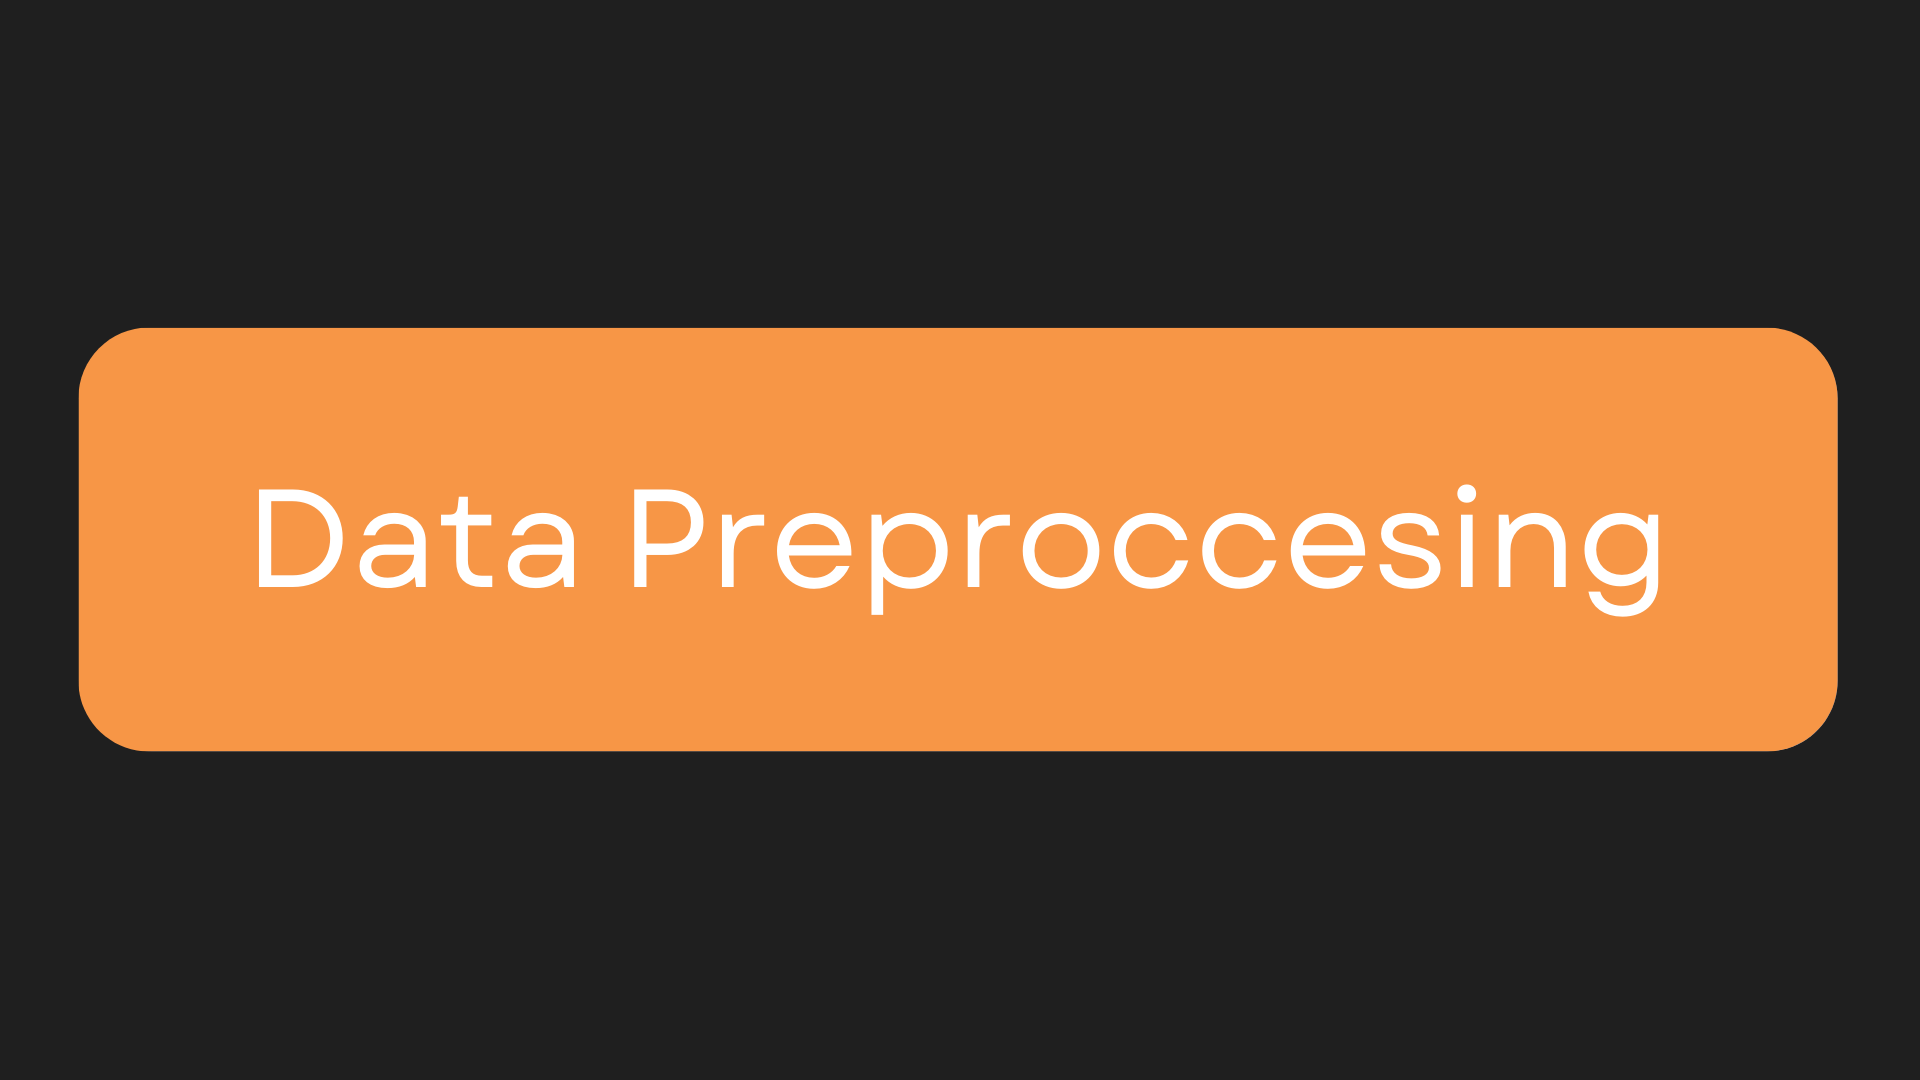

We will go through all the preprocessing steps to make sure our multimodal AI can process image and text data.

We have:

- Vocabulary Class
    - Builds our dictionary of words & maps words to indicies
- FlickrDataset Class
    - Converts transformed images and captions both as tensors
- MyCollate Class
    - Pads things so they are all the same length


In [ ]:
import os 
import torch 
import pandas as pd 
import nltk # Natural Language Toolkit
nltk.download("punkt")
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from torch.nn.utils.rnn import pad_sequence # From the RNN Library
from torch.utils.data import Dataset, DataLoader 
from torchvision.transforms import transforms
from PIL import Image  # Ensure PIL is imported
import matplotlib.pyplot as plt


class Vocabulary:
    def __init__(self, freq_threshold):
        # We need a way to convert from word to index and vice versa 
        self.index_to_word = {0: "<PAD>", 1: "<UNK>", 2: "< SOS >", 3: "<EOS>"}
        self.word_to_index = {"<PAD>": 0, "<UNK>": 1, "< SOS >": 2, "<EOS>": 3}
        self.freq_threshold = freq_threshold 

    def __len__(self):
        return len(self.index_to_word)

    @staticmethod
    def tokenizer(text):
        return [word for word in word_tokenize(text.lower())]

    def build_vocab(self, sentence_list):

        frequencies = {}
        start_idx = 4 # Start index of the vocabulary

        for sentence in sentence_list:
            tokens = self.tokenizer(sentence)
            for token in tokens:
                if token not in frequencies:
                    frequencies[token] = 1
                else:
                    frequencies[token] += 1
                if frequencies[token] == self.freq_threshold:
                    self.word_to_index[token] = start_idx
                    self.index_to_word[start_idx] = token
                    start_idx += 1

    def get_indices(self, sentence):
        '''
        Turn a sentence into a list of indices.

        Each word corresponds to an indices in the word_to_index dictionary we have built above 
        If a word does not exist then we return it as an Unkown ("UNK") token
        '''
        tokenized_text = self.tokenizer(sentence)
        return [
            self.word_to_index[word] if word in self.word_to_index else self.word_to_index["<UNK>"]
            for word in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, caption_file, transforms=None, freq_threshold=2):
        self.root_dir = root_dir 
        self.df = pd.read_csv(caption_file)
        self.transforms = transforms # Image transformations

        self.img_path = self.df["image"]
        self.captions = self.df["caption"]

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.img_path[idx]
        caption = self.captions[idx]

        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transforms:
            img = self.transforms(img)            

        numericalized_caption = [self.vocab.word_to_index["< SOS >"]]
        numericalized_caption += self.vocab.get_indices(caption)
        numericalized_caption.append(self.vocab.word_to_index["<EOS>"])

        # Image will be a torch tensor because it will be included in our transforms, we need to convert caption
        return img, torch.tensor(numericalized_caption)

# This object is to pad captions to ensure they are all the same length
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)

        captions = [item[1] for item in batch]
        padded_captions = pad_sequence(captions, batch_first=False, padding_value=self.pad_idx)

        return imgs, padded_captions

def get_loader(
    root_dir,
    captions_file, 
    transform,
    batch_size,
    shuffle=True,
    num_workers=8,
):
    dataset = FlickrDataset(root_dir, captions_file, transform)

    pad_idx = dataset.vocab.word_to_index["<PAD>"]

    data_loader = DataLoader(
        dataset, 
        batch_size=batch_size,
        num_workers=4,
        shuffle=shuffle,
        pin_memory=True, # Advanced Concept: Data placed in "VIP Section" of computer gets fast-track lane to the GPU when training
        collate_fn=MyCollate(pad_idx=pad_idx)
    )

    return data_loader, dataset

if __name__ == "__main__":
    transform = transforms.Compose(
        [transforms.Resize((224, 224)), transforms.ToTensor(),]
    )

    loader, dataset = get_loader(
        "data/images/", "data/text.csv", transform=transform
    )

    for idx, (imgs, captions) in enumerate(loader):
        print(imgs.shape)
        print(captions.shape)

        plt.imshow(imgs[0].squeeze(0).permute(1, 2, 0))
        plt.savefig("test_image.png")
        
        # Process the first caption in the batch
        print("Caption for the displayed image:")
        for i in range(captions.shape[0]):
            word_idx = captions[i, 0].item()  # Get the index at position i for the first caption (0)
            # Directly print the word using the vocabulary
            print(dataset.vocab.index_to_word.get(word_idx, "<UNK>"), end=" ")  

        input()

    